The code for master 2024 / sleep detection by edge device

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "train.csv"

df = pd.read_csv("./datas/" + filename)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19224\1772301478.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['x'], 'g.', label='x', linestyle='solid', marker=',')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19224\1772301478.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['y'], 'b.', label='y', linestyle='solid', marker=',')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19224\1772301478.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['z'], 'r.', label='z', linestyle='solid', marker=',')


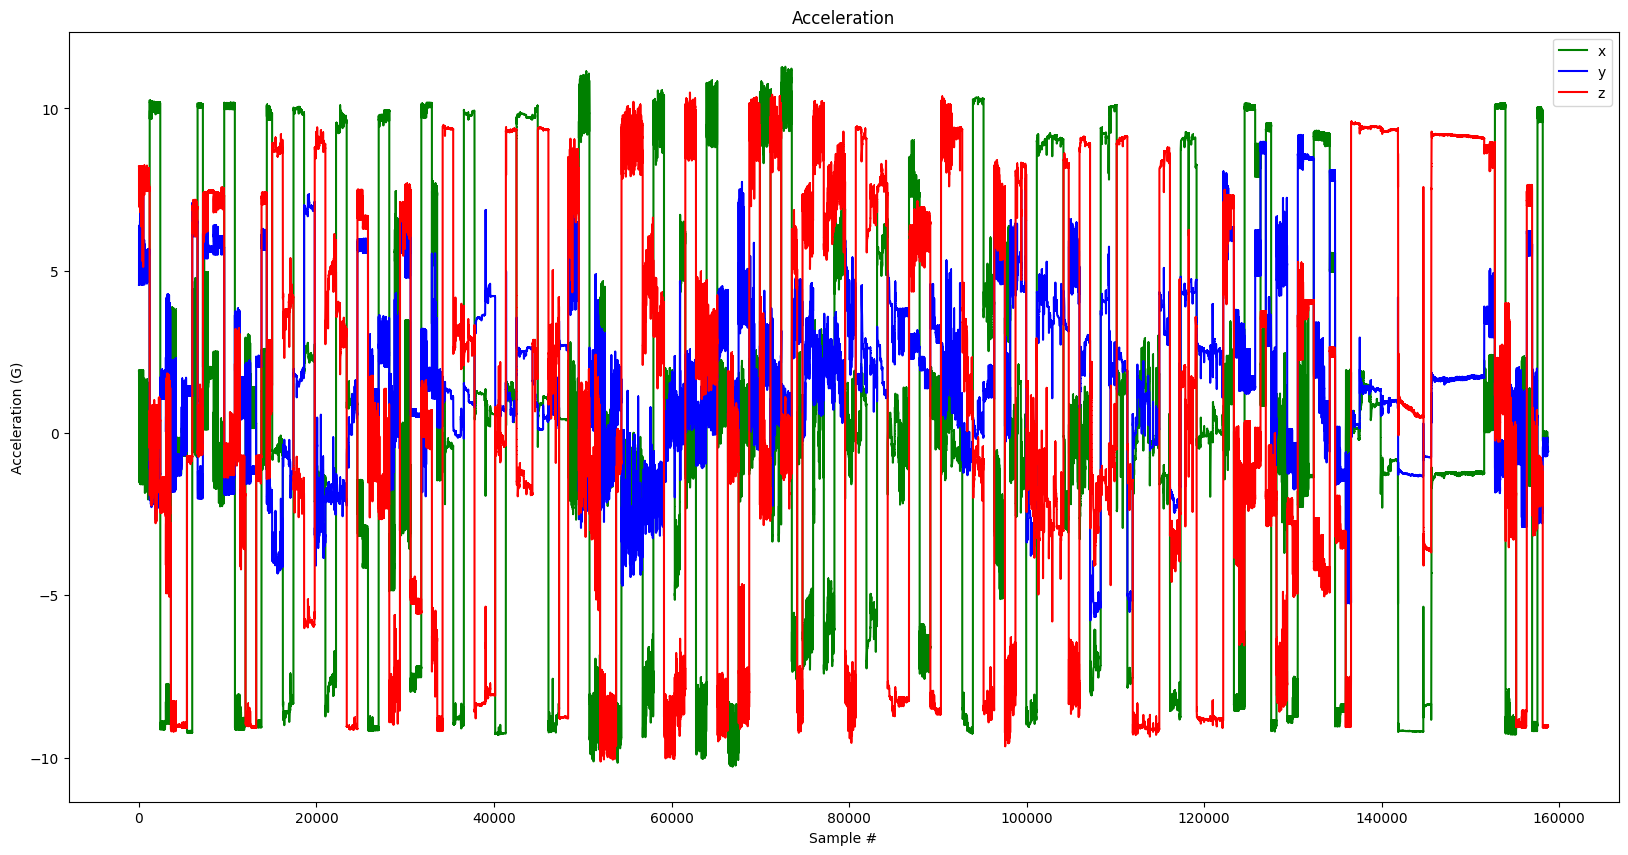

In [2]:
index = range(1, len(df['x']) + 1)
plt.rcParams["figure.figsize"] = (20, 10)

plt.plot(index, df['x'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['y'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['z'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

In [3]:
def create_training_data(data, window_size, step_size):
    NUM_GESTURES = 4
    ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
    x_list = []
    y_list = []
    z_list = []
    outputs = []
    for i in range(0, data.shape[0] - window_size, step_size):

        xs = data['x'].values[i: i + window_size]
        ys = data['y'].values[i: i + window_size]
        zs = data['z'].values[i: i + window_size]
      
        # Skip examples where the activity label changes within the window.
        if (i != i + window_size):
            if (data['activity'][i] != data['activity'][i+1]):
                print(i)
                continue

        label = ONE_HOT_ENCODED_GESTURES[data['activity'][i] - 1]
        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        outputs.append(label)

    
    x_list = np.array(x_list)
    y_list = np.array(y_list)
    z_list = np.array(z_list)
    outputs = np.array(outputs)
    
    
    return x_list, y_list, z_list, outputs

In [4]:
x_list, y_list, z_list, outputs = create_training_data(df, 20, 10)

In [5]:
print(len(x_list))
print(len(y_list))
print(len(z_list))
print(len(outputs))
print(np.array(x_list))

15873
15873
15873
15873
[[ 1.92   1.925  1.942 ... -0.452 -0.557 -0.565]
 [-0.427 -0.409 -0.407 ... -0.616 -0.671 -0.62 ]
 [-0.559 -0.587 -0.644 ... -0.686 -0.737 -0.771]
 ...
 [-0.58  -0.578 -0.577 ... -0.572 -0.57  -0.569]
 [-0.568 -0.567 -0.569 ... -0.572 -0.57  -0.57 ]
 [-0.567 -0.566 -0.576 ... -0.576 -0.574 -0.574]]


In [6]:
inputs = []
for i in range(len(x_list)):
    output = []
    for k in range(len(x_list[i])):
        output.append((x_list[i][k] + 12) / 24)
        output.append((y_list[i][k] + 12) / 24)
        output.append((z_list[i][k] + 12) /24)

    inputs.append(output)

inputs = np.array(inputs)

In [7]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [8]:
print(inputs.shape)
print(inputs_train.shape)
print(inputs[0])

(15873, 60)
(9523, 60)
[0.56829167 0.49825    0.144625   0.57166667 0.50804167 0.144375
 0.55675    0.49991667 0.126125   0.55920833 0.505375   0.126125
 0.56266667 0.51366667 0.12620833 0.56245833 0.51658333 0.12625
 0.56454167 0.52070833 0.12645833 0.56475    0.52220833 0.12658333
 0.5665     0.52183333 0.126375   0.56804167 0.52041667 0.12604167
 0.568375   0.51870833 0.12604167 0.56741667 0.517      0.12591667
 0.56683333 0.51666667 0.12591667 0.565625   0.51516667 0.1255
 0.56475    0.51383333 0.12533333 0.54825    0.49704167 0.10916667
 0.54725    0.49683333 0.10908333 0.54658333 0.49675    0.10904167
 0.54583333 0.4965     0.10891667 0.54533333 0.49675    0.10891667]


In [9]:
# build the model and train it
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=30, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 5s 447us/step - loss: 0.0259 - mae: 0.0712 - val_loss: 0.0038 - val_mae: 0.0089
Epoch 2/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 4s 429us/step - loss: 0.0060 - mae: 0.0114 - val_loss: 0.0060 - val_mae: 0.0114
Epoch 3/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 4s 439us/step - loss: 0.0048 - mae: 0.0086 - val_loss: 0.0038 - val_mae: 0.0067
Epoch 4/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 4s 424us/step - loss: 0.0045 - mae: 0.0076 - val_loss: 0.0035 - val_mae: 0.0054
Epoch 5/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 4s 435us/step - loss: 0.0033 - mae: 0.0054 - val_loss: 0.0022 - val_mae: 0.0037
Epoch 6/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 4s 436us/step - loss: 0.0033 - mae: 0.0057 - val_loss: 0.0017 - val_mae: 0.0029
Epoch 7/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 4s 434us/step - loss: 0.0028 - mae: 0.0044 - val_loss: 0.0032 - val_mae: 0.0053
Epoch 8/30
9523/9523 ━━━━━━━━━━━━━━━━━━━━ 4s 425us/step - loss: 0.0028 - mae: 0.0047 - val_loss: 0.0017 - val_mae: 0.0032
Epoch 9/30
9523/9523 ━━━

In [10]:
predictions = model.predict(inputs_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


In [ ]:
convert_pred = converted_array = np.where(predictions >= 0.8, 1, 0)
print(convert_pred)
print(outputs_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(outputs_test, convert_pred)
print("Accuracy:", accuracy)
# confusion_matrix(outputs_test, convert_pred)

# print("Accuracy:", accuracy_score(outputs_test, convert_pred))
# print("\n -------------Classification Neural Network Report-------------\n")
# print(classification_report(outputs_test, convert_pred))

[[1 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 ...
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
Accuracy: 0.994328922495274


ValueError: multilabel-indicator is not supported

In [12]:
import numpy as np

# Chuyển đổi dataTTT sang numpy array
dataTTT = np.array([[0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92,
                     0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.51, 0.92,
                     0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92,
                     0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92,
                     0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92, 0.49, 0.50, 0.92]])

# Dự đoán
res = model.predict(dataTTT)
print(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[1.0000000e+00 3.1449060e-12 4.5963418e-08 1.1201514e-16]]


In [13]:
print(model)

<Sequential name=sequential, built=True>


In [14]:
# Convert the model to the TensorFlow Lite format without quantization
model.save("model_original.h5")

# Kiểm tra kích thước file
import os
keras_model_size = os.path.getsize("model_original.h5")
print("Original Keras model size: %d bytes (%.2f KB)" % (keras_model_size, keras_model_size / 1024))
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("3-6.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("3-6.tflite")
print("Model is %d bytes" % basic_model_size)

  

Original Keras model size: 56496 bytes (55.17 KB)
INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpawjew3tw\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpawjew3tw\assets


Saved artifact at 'C:\Users\Admin\AppData\Local\Temp\tmpawjew3tw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 60), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(1, 4), dtype=tf.float32, name=None)
Captures:
  2001523728880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523735392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523726768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523974288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523972880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523977808: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 17496 bytes


In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()

with open("model_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)

quant_model_size = os.path.getsize("model_quant.tflite")
print("Quantized TFLite model size: %d bytes (%.2f KB)" % (quant_model_size, quant_model_size / 1024))


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp227yq490\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp227yq490\assets


Saved artifact at 'C:\Users\Admin\AppData\Local\Temp\tmp227yq490'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 60), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(1, 4), dtype=tf.float32, name=None)
Captures:
  2001523728880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523735392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523726768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523974288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523972880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2001523977808: TensorSpec(shape=(), dtype=tf.resource, name=None)
Quantized TFLite model size: 9184 bytes (8.97 KB)


In [15]:
#  chạy bằng terminal thường
# echo "const unsigned char model[] = {" > ./model.h
# cat position_model.tflite | xxd -i      >> ./model.h
# echo "};"                              >> ./model.h

import os

model_h_size = os.path.getsize("model.h")

print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 107,952 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
